In [1]:
import pandas as pd       
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

import glob

import warnings
warnings.filterwarnings('ignore')

2021-12-28 23:36:50.813667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-28 23:36:50.813691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Config data
IMG_SIZE = 224
BATCH = 32
SEED = 1

In [3]:
# Set path for images
train_normal = glob.glob("chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("chest_xray/test/PNEUMONIA/*")

In [4]:
# Build dataframe of dataset
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

<AxesSubplot:xlabel='class', ylabel='count'>

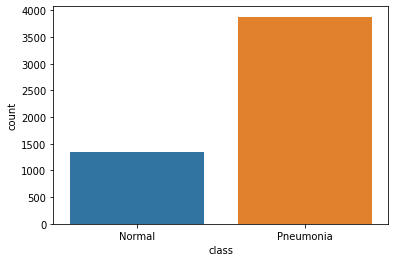

In [5]:
sns.countplot(data=df_train, x="class")

<AxesSubplot:xlabel='class', ylabel='count'>

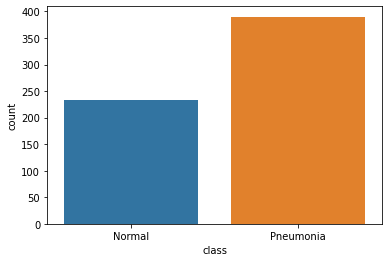

In [6]:
sns.countplot(data=df_test, x="class")

Number of Normal and Pneumonia datas are not skewed. Hence, accuracy score is a good validation criteria.

In [7]:
# Split images to training and validation use.
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [14]:
# Scale and generate more images for training for higher model accuracy.
train_datagen = ImageDataGenerator(zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1)

# Input images into image data generator
ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [15]:
# Load ResNet-152 for transfer learning & remove last layer of VGG16
base_model = tf.keras.applications.ResNet152(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (IMG_SIZE, IMG_SIZE, 3))

# Freeze training for ResNet layers
base_model.trainable = False

# Build model
def get_pretrained():    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) 
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1, activation='sigmoid')(x)  
    model = keras.Model(inputs=[inputs], outputs=output)   
    return model

In [16]:
keras.backend.clear_session()

# Build model and set loss as binary_crossentropy
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [17]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

In [18]:
# Fit model
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 10,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/10
130/130 [==============================] - 396s 3s/step - loss: 0.3230 - binary_accuracy: 0.8569 - val_loss: 0.1861 - val_binary_accuracy: 0.9245 - lr: 5.0000e-05
Epoch 2/10
130/130 [==============================] - 391s 3s/step - loss: 0.1760 - binary_accuracy: 0.9295 - val_loss: 0.1731 - val_binary_accuracy: 0.9293 - lr: 5.0000e-05
Epoch 3/10
130/130 [==============================] - 394s 3s/step - loss: 0.1439 - binary_accuracy: 0.9436 - val_loss: 0.1363 - val_binary_accuracy: 0.9522 - lr: 5.0000e-05
Epoch 4/10
130/130 [==============================] - 389s 3s/step - loss: 0.1308 - binary_accuracy: 0.9470 - val_loss: 0.1272 - val_binary_accuracy: 0.9551 - lr: 5.0000e-05
Epoch 5/10
130/130 [==============================] - 385s 3s/step - loss: 0.1249 - binary_accuracy: 0.9541 - val_loss: 0.1177 - val_binary_accuracy: 0.9647 - lr: 5.0000e-05
Epoch 6/10
130/130 [==============================] - 384s 3s/step - loss: 0.1156 - binary_accuracy: 0.9553 - val_loss: 0.1303 - v

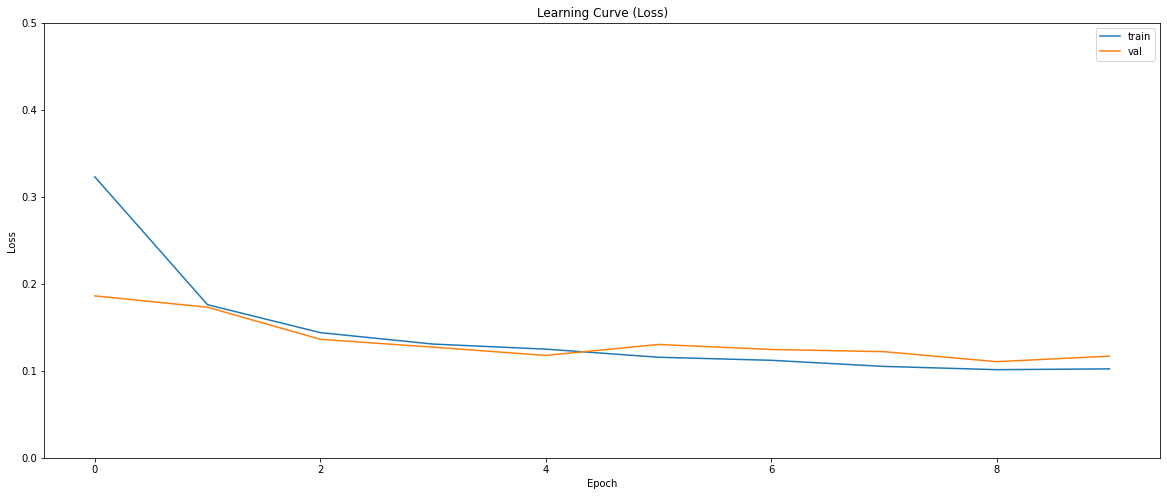

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [20]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.11689513176679611
Val accuracy: 0.958930253982544


In [21]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16918744146823883
Test accuracy: 0.9375


In [22]:
# Save model
model_pretrained.save('Xray_model_res')

2021-12-22 23:15:12.326893: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Xray_model_res/assets


In [2]:
#Load model
new_model = tf.keras.models.load_model('Xray_model_res')

2021-12-28 23:36:57.319088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ken/git_repo/transfer_learning_xray/venv/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-28 23:36:57.319112: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-28 23:36:57.319125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dreamer): /proc/driver/nvidia/version does not exist
2021-12-28 23:36:57.319491: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


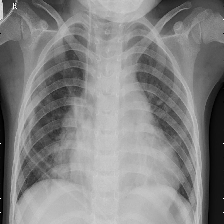

In [7]:
# Import X-ray image and display it
img_path = 'chest_xray/test/PNEUMONIA/BACTERIA-40699-0001.jpeg'
img = load_img(img_path,color_mode='rgb', target_size=(224, 224))
display(img)

In [8]:
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

In [9]:
x = preprocess_input(x)
features = new_model.predict(x)
features

array([[0.99895656]], dtype=float32)